In [1]:
import pandas as pd
from data import make_grid
import numpy as np
from itertools import product
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import linregress

from sklearn.model_selection import cross_validate
from sklearn.metrics import auc, r2_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
data = make_grid("GB", 0.1)
print()
data.info()

Matching birds to grid cells: 

 98%|█████████▊| 98/100 [00:06<00:00, 14.83it/s]/Users/leoware/Documents/ns166_final_analysis/data/make_grid.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[spec] = counts
100%|██████████| 100/100 [00:06<00:00, 14.72it/s]



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3349 entries, 0 to 3348
Columns: 106 entries, lat to Vanellus vanellus
dtypes: float64(6), int64(100)
memory usage: 2.7 MB


In [3]:
id_col = ['lat', 'lon']
cov_col = ['avg_temp', 'avg_min_month', 'avg_max_month']
target_col = list(set(data.columns) - set(id_col) - set(cov_col))

In [31]:
other_birds_r2 = []
cov_resid_r2 = []
bird_hat = {}

for bird in target_col:
    not_bird = list(set(target_col) - set([bird]))
    not_bird_count = data[not_bird].sum(axis=1)

    model = LinearRegression()
    model.fit(not_bird_count.values.reshape(-1, 1), data[bird])
    y_hat = model.predict(not_bird_count.values.reshape(-1, 1))
    bird_hat[bird] = y_hat

    other_birds_r2.append(r2_score(data[bird], y_hat))

    resid = data[bird] - y_hat

    resid_model = LinearRegression()
    resid_model.fit(data[cov_col], resid)

    cov_resid_r2.append(r2_score(resid, resid_model.predict(data[cov_col])))

In [24]:
other_birds_r2 = np.array(other_birds_r2)
cov_resid_r2 = np.array(cov_resid_r2)

other birds 0.39076119749730515 0.06843893156261394 0.7452302040675365


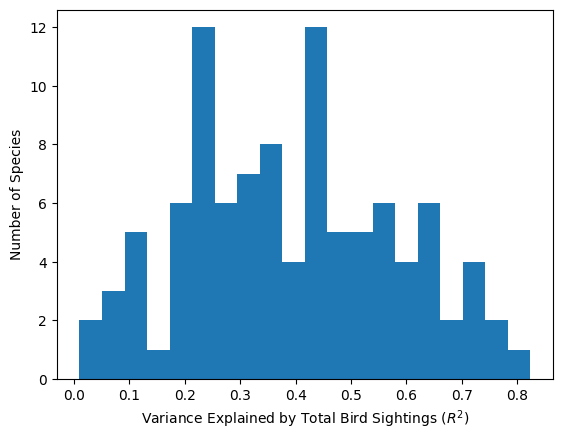

In [15]:
print("other birds", np.mean(other_birds_r2), np.quantile(other_birds_r2, 0.025), np.quantile(other_birds_r2, 0.975))
plt.hist(other_birds_r2, bins=20)
plt.xlabel("Variance Explained by Total Bird Sightings ($R^2$)")
plt.ylabel("Number of Species")
plt.show()

0.02758827377798693 0.0009927307542730301 0.08053407719148975


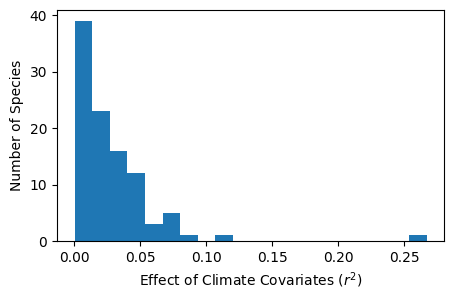

In [30]:
print(np.mean(cov_resid_r2), np.quantile(cov_resid_r2, 0.025), np.quantile(cov_resid_r2, 0.975))
plt.figure(figsize=(5, 3))
plt.hist(cov_resid_r2, bins=20)
plt.xlabel("Effect of Climate Covariates ($r^2$)")
plt.ylabel("Number of Species")
plt.show()

In [26]:
print((cov_resid_r2 > 0.05).mean(), 0.05**0.5)
print((cov_resid_r2 > 0.1).mean(), 0.1**0.5)


0.13861386138613863 0.22360679774997896
0.019801980198019802 0.31622776601683794


LinregressResult(slope=0.0401717413761901, intercept=0.011890716012274843, rvalue=0.23111287230732114, pvalue=0.020054860028231706, stderr=0.01699648662805634, intercept_stderr=0.007379374507239417)

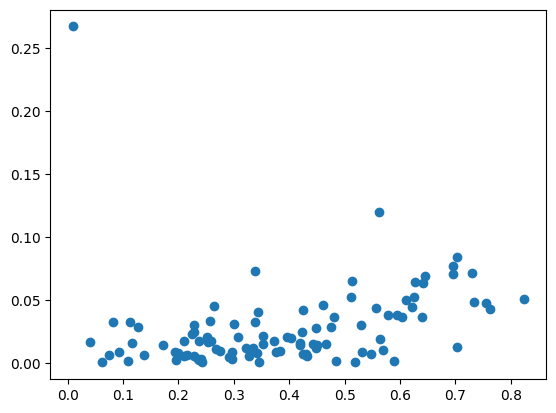

In [20]:
plt.plot(other_birds_r2, cov_resid_r2, 'o')
linregress(other_birds_r2, cov_resid_r2)

array([[<Axes: title={'center': 'avg_temp'}>,
        <Axes: title={'center': 'avg_min_month'}>],
       [<Axes: title={'center': 'avg_max_month'}>, <Axes: >]],
      dtype=object)

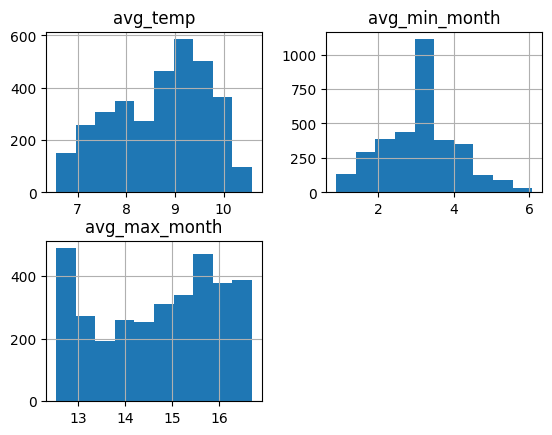

In [21]:
data[cov_col].hist()

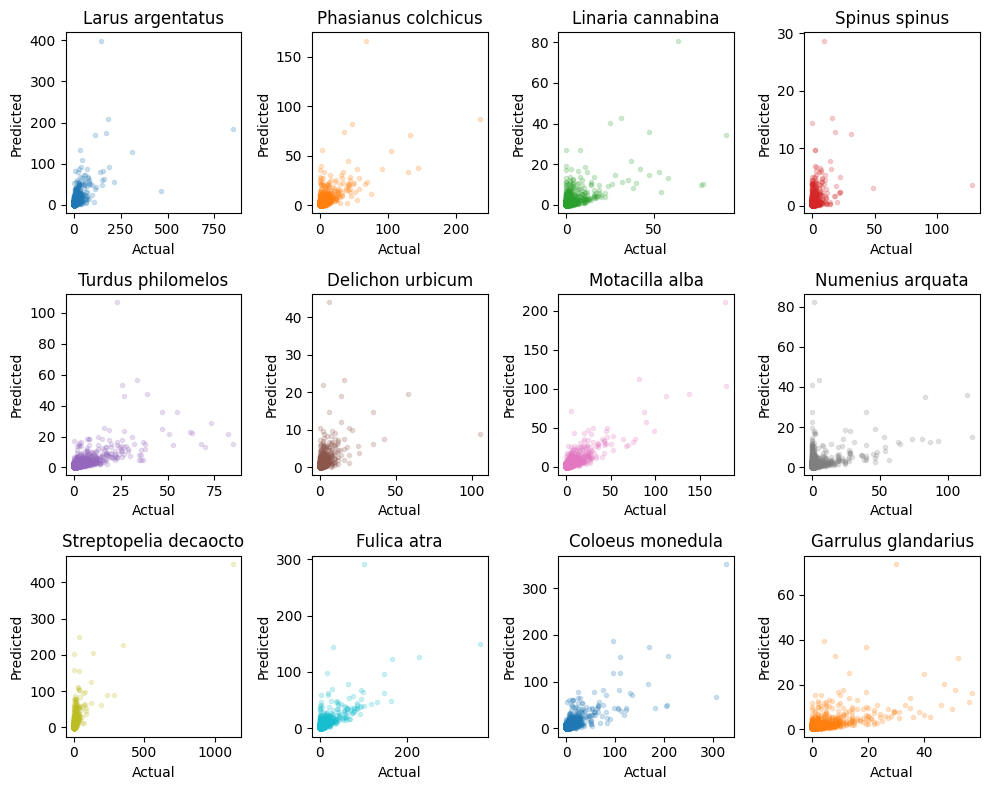

In [47]:
np.random.seed(42)

bk = np.array(list(bird_hat.keys()))
picks = np.random.choice(bk, 12, replace=False)

fig, axs = plt.subplots(3, 4, figsize=(10, 8))
axs = iter(axs.flat)

i = 0
for bird in picks:
    ax = next(axs)
    ax.plot(data[bird], bird_hat[bird], ".", color=f"C{i}", alpha=0.2)
    ax.set_title(bird)
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    i += 1

plt.tight_layout()
plt.savefig("imgs/bird_hat.png", dpi=300)